<h1>Finding 4 letter Palindromes using Grover Search<h1>

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble
from qiskit.compiler import transpile, assemble
from qiskit.circuit import Gate
from qiskit.circuit.library.standard_gates import *
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_city, plot_state_qsphere, array_to_latex, circuit_drawer
from qiskit.quantum_info import Statevector, random_statevector, Operator
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit.library import QFT

import matplotlib.pyplot as plt
import numpy as np
import math

In many basic python courses, one of the common exercises is to write a fucntion called isPalindrome() which checks whether a given input string is a palindrome. Palindromes also appear in genetic sequences but in a slightly form and therefore finding palindromes could always have a potential application.    
In this project, the palindromes will consist of the letters A, G, C and T. I have chosen these letters as in the context of genetics these letters stand as acronyms for the molecules adenine (A), cytosine (C), guanin (G), and thymine (T) found inside strands of DNA. The Grover search implemented in this project can find all the palindromes consisting of the letters in A, G, C and T. If the circuit is only run once, then the circuit can find only one valid palindrome.

|Letter |Binary representation | 
|:---:|:---:|
| A | 00 | 
| G | 01 | 
| C | 10 | 
| T | 11 | 

The basic circuit scheme of the Grover Search is based on the Qiskit textbook __[tutorial](https://qiskit.org/textbook/ch-algorithms/grover.html)__.
In order to first implement the Grover algorithm, we need to implement the appropriate Grover algorithm. First we construct a custom multi qubit X gate with control states set as 0.

In [2]:
q = QuantumCircuit(1)
q.x(0)
X_gate = q.to_gate()
Zero_control_gate = X_gate.control(2, ctrl_state = 0)

In order for a four letter string to be a palindrome, the first and the last letter have to be identical and so do the second and the third letter. For example : AGGA, ATTA or CGGC. Therefore the state of the qubits representing the letter 1 and letter 4 should be identical and so should be the case for the qubits respresenting letter 2 and letter 3.

Each state representing a letter consists of 2 qubits, hence if two letters i.e two states have to be the same, then each qubit of one letter should match with the qubit of the other letter occupying the same position.
For example : the state 10 will be equal to a state xy if x = 1 and y = 1.

Therefore a simple circuit using mct (multi qubit Toffoli gates, same as multi qubit X gates) and the custom Not gates defined above can output the result as 1 (X gate applied on output register) representing equality and 0 (X gate not applied) represnting not equal :

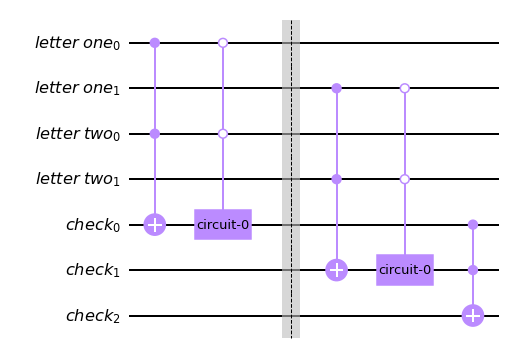

In [3]:
output = QuantumRegister(3, 'check')
letterOne = QuantumRegister(2, 'letter one')
letterTwo = QuantumRegister(2, 'letter two')

Compare_two_letters = QuantumCircuit(letterOne, letterTwo, output)

Compare_two_letters.mct([letterOne[0], letterTwo[0]], output[0])
Compare_two_letters.append( Zero_control_gate, [letterOne[0], letterTwo[0], output[0]] )
Compare_two_letters.barrier()
Compare_two_letters.mct([letterOne[1], letterTwo[1]], output[1])
Compare_two_letters.append( Zero_control_gate, [letterOne[1], letterTwo[1], output[1]] )

Compare_two_letters.mct([output[0], output[1]], output[2])

Compare_two_letters.draw()

We can extend this circuit for our particular four letters by omitting the last mct gate for now :

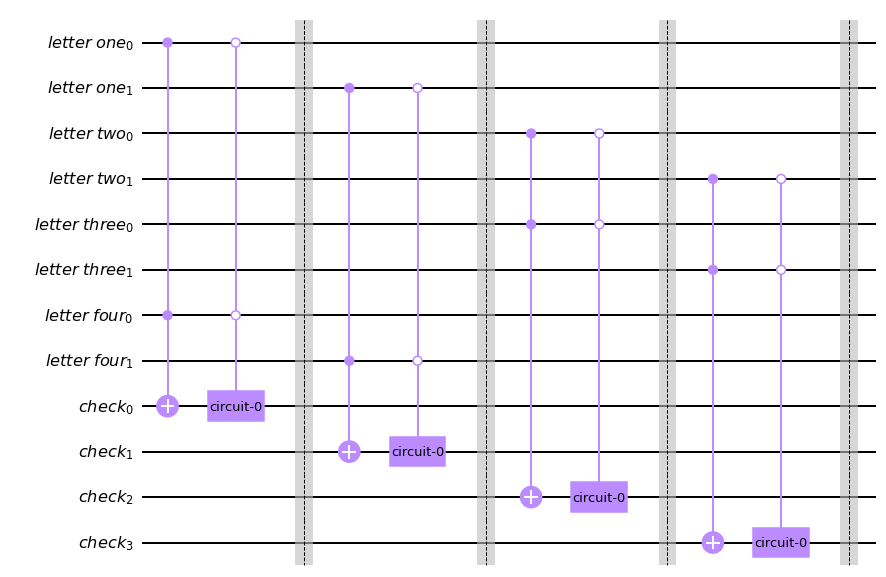

In [4]:
Checkbits = QuantumRegister(4, 'check')
letterOne = QuantumRegister(2, 'letter one')
letterTwo = QuantumRegister(2, 'letter two')
letterThree = QuantumRegister(2, 'letter three')
letterFour = QuantumRegister(2, 'letter four')

AcillaRegister = QuantumRegister(1, 'ancilla')
detector_circuit = QuantumCircuit(letterOne, letterTwo, letterThree, letterFour, Checkbits)

for i in range(0, 4, 2):
    for j in range(2):
        detector_circuit.mct([i+j, 8-i-2+j], 8+i+j) # when the qubits are in state 1
        detector_circuit.append(Zero_control_gate, [i+j, 8-i-2+j, 8+i+j]) # when the qubits are in state 0
        detector_circuit.barrier()


detector_circuit.draw()

The above circuit uses barrier() function which makes it easier but the barrier() function also transpiles the section of circuits across the barriers separately therefore this can potentially cut down any chances of optimization. In order to avoid this I have rewritten the circuit below with barriers commented out.

In [5]:
# The above circuit uses the barrier operation therefore is better for 
# visualizing the circuit but inefficient when it comes to traspilation

detector_circuit = QuantumCircuit(12)

for i in range(0, 4, 2):
    for j in range(2):
        detector_circuit.mct([i+j, 8-i-2+j], 8+i+j) # when the qubits are in state 1
        detector_circuit.append(Zero_control_gate, [i+j, 8-i-2+j, 8+i+j]) # when the qubits are in state 0
        #detector_circuit.barrier()

detector_gate = detector_circuit.to_gate()# Convert circuit to gate
inverse_detector_gate = detector_circuit.to_gate().inverse() # Convert circuit to gate and invert it


If you have read the Grover algorithm tutorial from Qiskit, you by now know that the significance of the the last mct gate is it transfers the output into an ancilla qubit. After that you should by now know that the circuit before the mct needs to be uncomputed or in other words inverted and this what is done in the circuit below : 


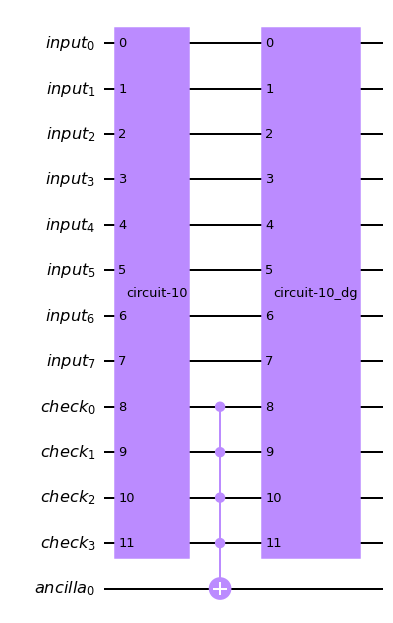

In [6]:
#Creating the boolean oracle for the search

InputRegister = QuantumRegister(8, 'input')
AncillaRegister = QuantumRegister(1, 'ancilla')
oracle_circuit = QuantumCircuit(InputRegister, Checkbits, AncillaRegister)

oracle_circuit.append(detector_gate, range(12)) #check whether it is palindrome

oracle_circuit.mct([8, 9, 10, 11], 12) #transfer the result to ancilla bit

oracle_circuit.append(inverse_detector_gate, range(12)) #uncomputation step of Grover oracle

oracle_gate = oracle_circuit.to_gate() #converts oracle to a gate

oracle_circuit.draw()

This completes the oracle for the search and the kind of oracle implemented in this project is a boolean oracle. In the Qiskit Grover search tutorial or elsewhere in the literature you may have encountered a different type of oracle called phase oracle. Both types of oracles perform the same unitary operation on the state of the qubits from the search register but the boolean one requires an extra ancilla qubit whereas the phase one doesn't.

In [7]:
U1 = Operator(oracle_circuit)
array_to_latex(U1) #matrix representation of the oracle

<IPython.core.display.Latex object>

The second gate required for completing the Grover search circuit is amplitude amplification gate or the diffsuion operator. The circuit scheme used here is one found across the literature though there are minute differences at times. 

In [8]:
def diffusor(n): #function for creating abritrary size diffusion operator
    qr = QuantumRegister(n)
    q = QuantumCircuit(qr)
    for i in range(n):
        q.h(i)
        q.x(i)
        
    q.h(n-1)
    q.mct(qr[:-1], qr[n-1])
    q.h(n-1)
    
    for i in range(n):
        q.x(i)
        q.h(i)
    return q
n = 8 #as there are 8 qubits in the Input Register representing four qubits
diffusion_8 = diffusor(n).to_gate()

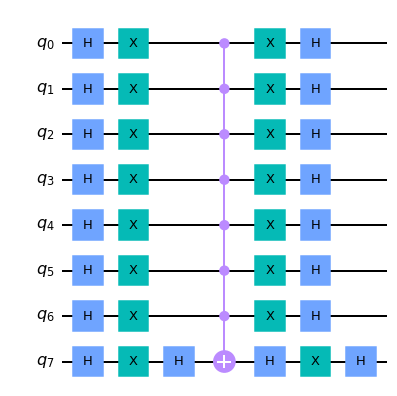

In [9]:
q = QuantumCircuit(n)
q.append(diffusion_8, range(n))
q.decompose().draw()

In [10]:
U2 = Operator(diffusion_8)
array_to_latex(U2) #matrix representation of the 8 qubit representation

<IPython.core.display.Latex object>

Grover search's sole advantge for classical search algorithm with time complexity of $O(N)$ is it gives a qudratic speedup $O(\sqrt{N})$ in case of one solution. In precise terms both oracle and diffusion operator need to applied $[\frac{\pi\sqrt{N}}{4}]$ times. The derivation for this is fairly simple is shown in the Qiskit tutorial.

In case of $M$ solutions, the required number of iterations becomes $[\frac{\pi\sqrt{N/M}}{4}]$.
But there is a problem...
The value of $M$, the number of solutions, is not known for this particular problem. In order to find these solutions we need to use the the __[Quantum Counting algorithm](https://qiskit.org/textbook/ch-algorithms/quantum-counting.html)__. The theory and derivation of the circuit scheme exists on the Qiskit tutorial website. 

In order to use Quantum Counting to find the number of solution we need to simply convert for circuit the Grover search consisting of 2 gates into one gate representing a Grover operator and subsequently create it's single qubit controlled gate.

In [11]:
def Grover_Gate(n, t, oracle, diffusor): #Create Grover gate
    qc = QuantumCircuit(n)
    qc.append(oracle_gate, range(n))
    qc.append(diffusor, range(t))
    return qc
bit_len = 5 #the number of counting qubits representing the output which leads to the number of solutions
Gate_size = 13 #the oracle requires 13 qubits and 8 for diffusion operator hence 13 qubits for the Grover gate
InputSize = 8 #the number of qubits represnting the output of the Grover gate
grit = Grover_Gate(Gate_size, InputSize, oracle_gate, diffusion_8).to_gate()
cgrit = grit.control()
cgrit.label = "My Grover gate"

We also need an inverse quantum fourier transform gate. The one written below is the exact same as the one on the Qiskit website :

In [12]:
def qft(n): #Create quantum_fourier transform gate
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [13]:
qft_dagger = qft(bit_len).to_gate().inverse()
qft_dagger.label = "QFT†"

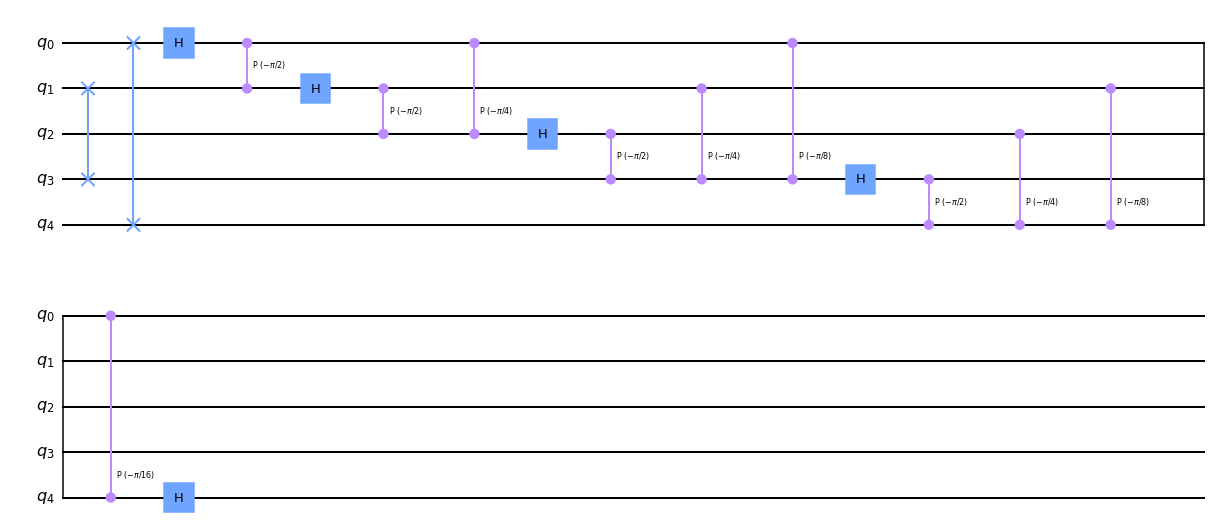

In [14]:
q = QuantumCircuit(bit_len)
q.append(qft_dagger, range(bit_len))
q.decompose().draw() #5 bit fourier transform decomposed

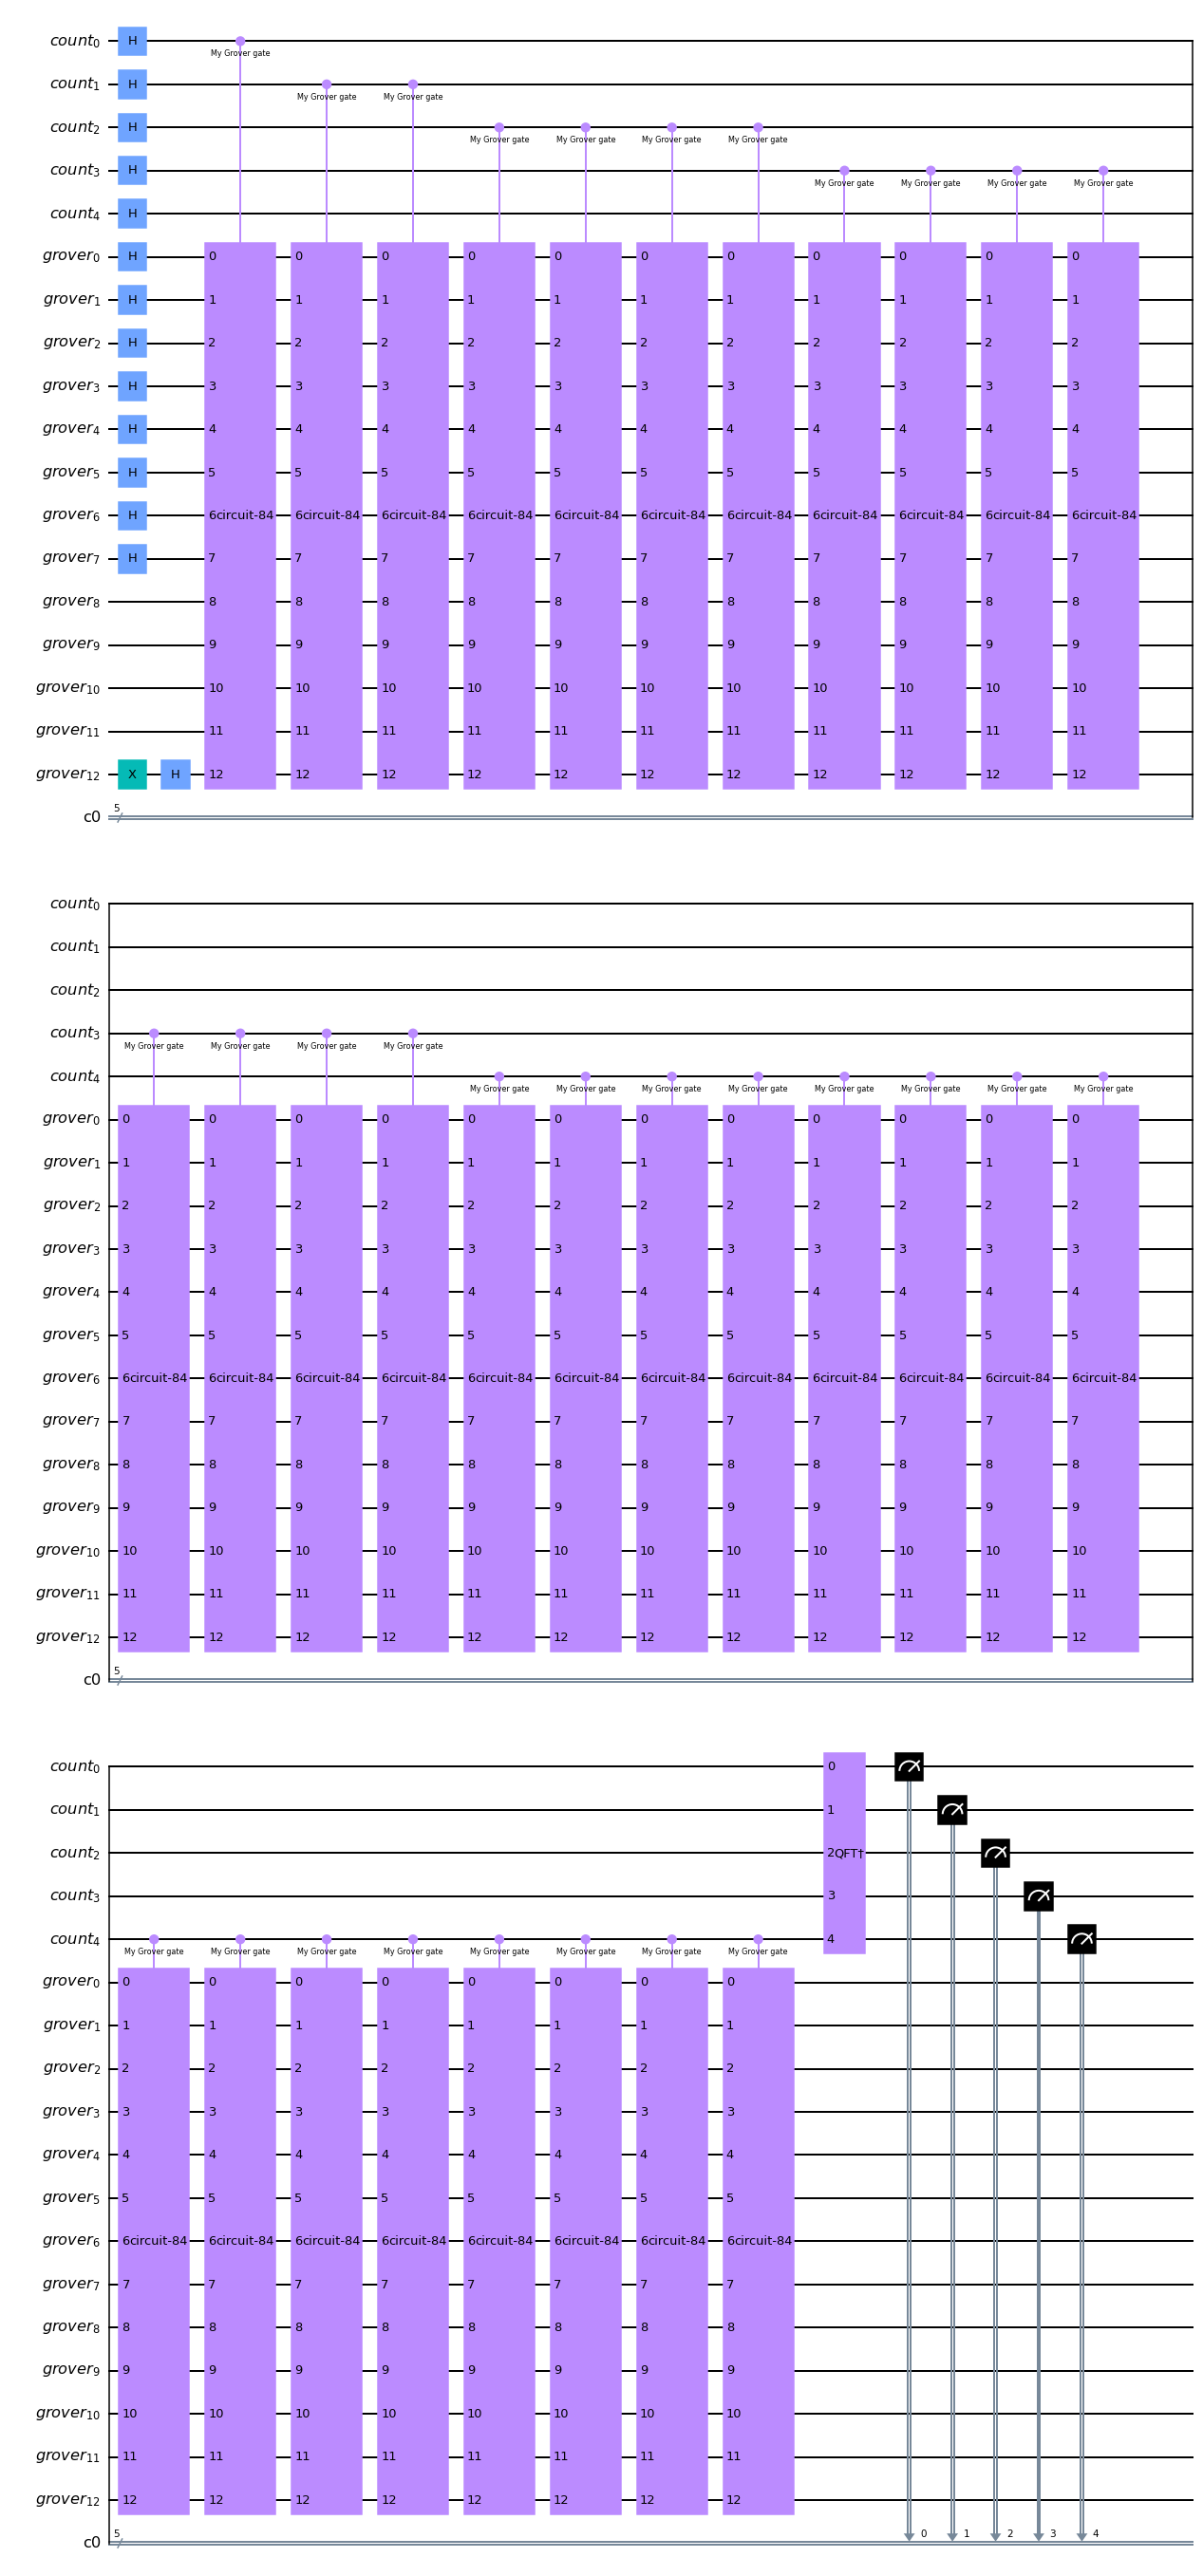

In [15]:
CoutingRegister = QuantumRegister(bit_len, 'count')
Grover_qubits = 13
GroverRegister = QuantumRegister(Grover_qubits, 'grover')
Classical_CountingRegister = ClassicalRegister(bit_len)
quantumCounting_circuit = QuantumCircuit(CoutingRegister, GroverRegister, Classical_CountingRegister)

for i in range(bit_len+n): #initial superposition for the couting qubits and the input register of the Grover gate
    quantumCounting_circuit.h(i)
quantumCounting_circuit.x(-1)
quantumCounting_circuit.h(-1)
iterations = 1
for qubit in range(bit_len):
    for i in range(iterations):# apply the control gate for each qubit 2**(index+1) times
        quantumCounting_circuit.append(cgrit, [qubit]+[*range(bit_len, bit_len+Grover_qubits)])
    iterations *= 2 
    
quantumCounting_circuit.append(qft_dagger, range(bit_len))
quantumCounting_circuit.measure(range(bit_len),  range(bit_len))

quantumCounting_circuit.draw()

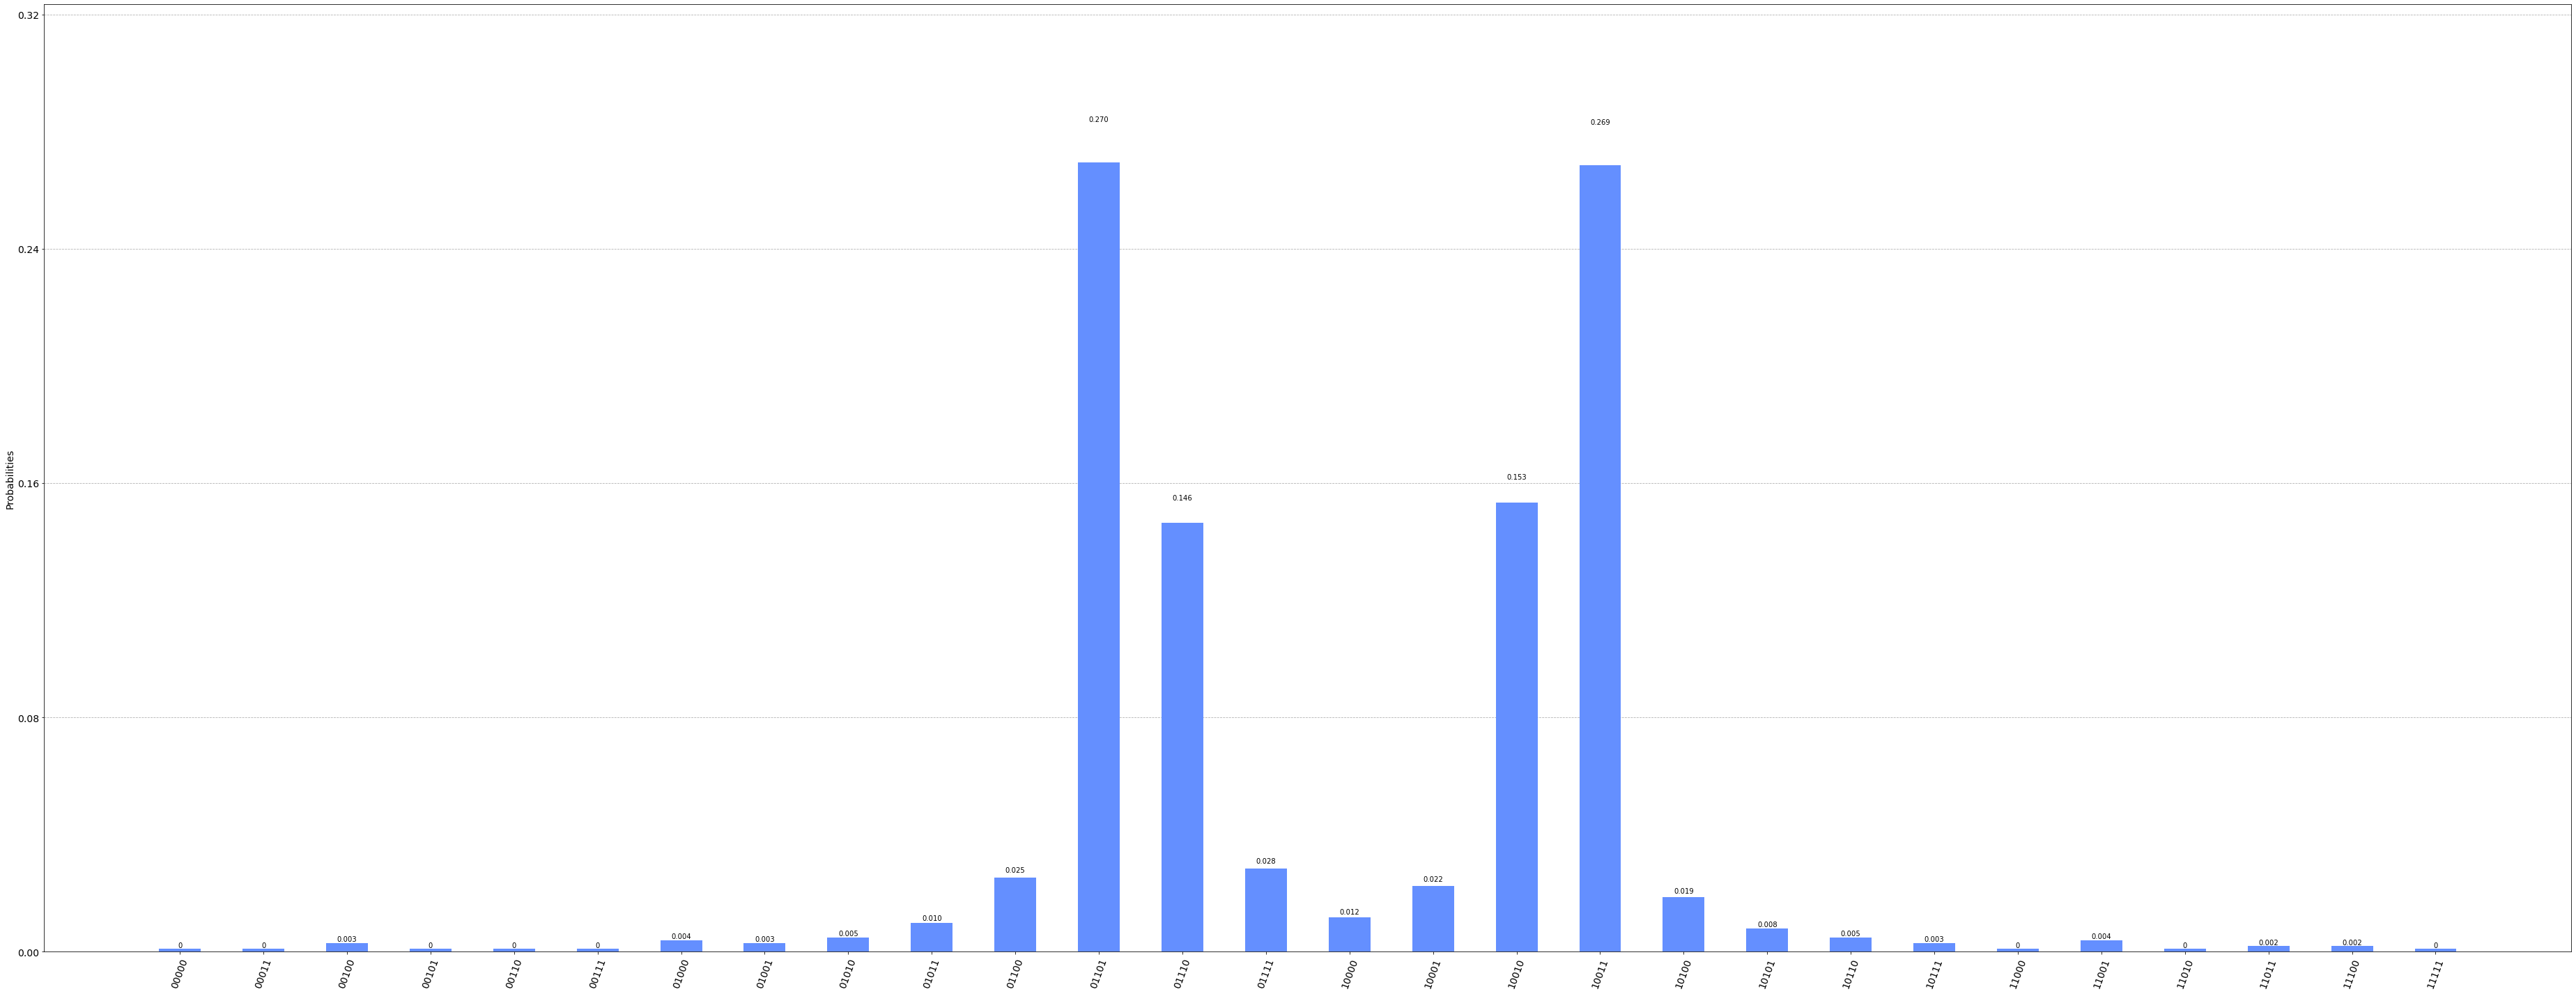

In [16]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
job = execute(quantumCounting_circuit, backend, shots = shots)
results = job.result()
counts = results.get_counts()
plot_histogram(counts, figsize=(65, 25))

In [17]:
measured_str = max(counts, key=counts.get)
measured_int = int(measured_str,2)
increment = counts.get(format((measured_int+1)%2**bit_len, '05b'), -1)/counts.get(format(measured_int, '05b'), -1) 
decrement = -counts.get(format((measured_int-1)%2**bit_len, '05b'), -1)/counts.get(format(measured_int, '05b'), -1)

measured_float = measured_int + increment + decrement 
print("Register Output = %i" % measured_float)
theta = (measured_float/(2**bit_len))*math.pi*2
print("Theta = %.5f" % theta)
N = 2**InputSize
M = N * (math.sin(theta/2)**2)
approx_solutions = round(N-M)
print("No. of Solutions = %.1f" % approx_solutions)

Register Output = 13
Theta = 2.64076
No. of Solutions = 16.0


We now have the approximate number of solutions. The real solution may differ by +1 or -1 but the approximation is precise enough for us to determine the number of times the Grover gate must be applied in order to obtain the solutions.
The circuit below is the full Grover search circuit for the palindrome problem :

Required number of Grover iterations =  3


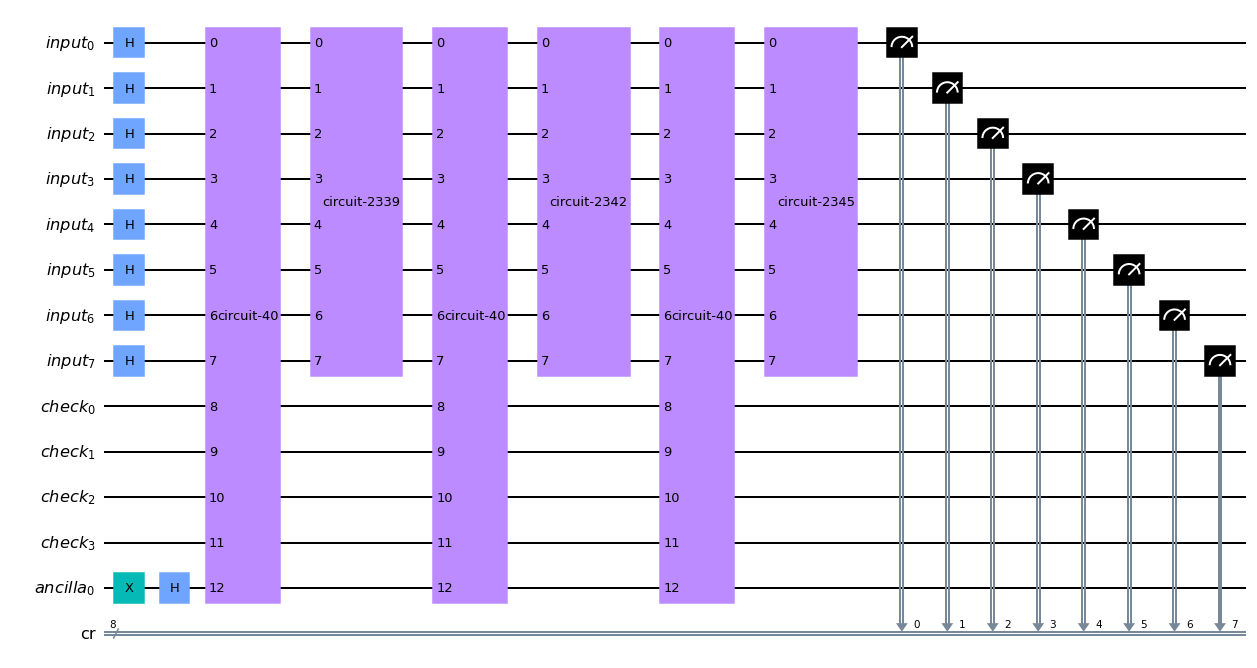

In [18]:
t = Gate_size
n = InputSize
cr = ClassicalRegister(InputSize, 'cr')
Grover_circuit = QuantumCircuit(InputRegister, Checkbits, AncillaRegister, cr)

Grover_circuit.h(range(n)) #inital superposition

# initialize ancilla in hadamard state |->
Grover_circuit.x(12)
Grover_circuit.h(12)

#N = 2**n and M is the number of solutions
#required number of iterations is (pie/4)(sqrt(N/M))

m = approx_solutions
iterations = int( (math.pi/4) * math.sqrt((2**n/m)) )

for i in range(iterations):
    Grover_circuit.append(oracle_gate, range(t))
    Grover_circuit.append(diffusor(n).to_gate(), range(n))

Grover_circuit.measure(range(n), range(n))
print("Required number of Grover iterations = ", iterations)
Grover_circuit.draw()

Running the circuit would ouput one of the palindromes but when the circuit is run 4096 times, the output distribution shows a clear bias towards the right solutions.

Find palindromes amongst the letters A, G, T, C :


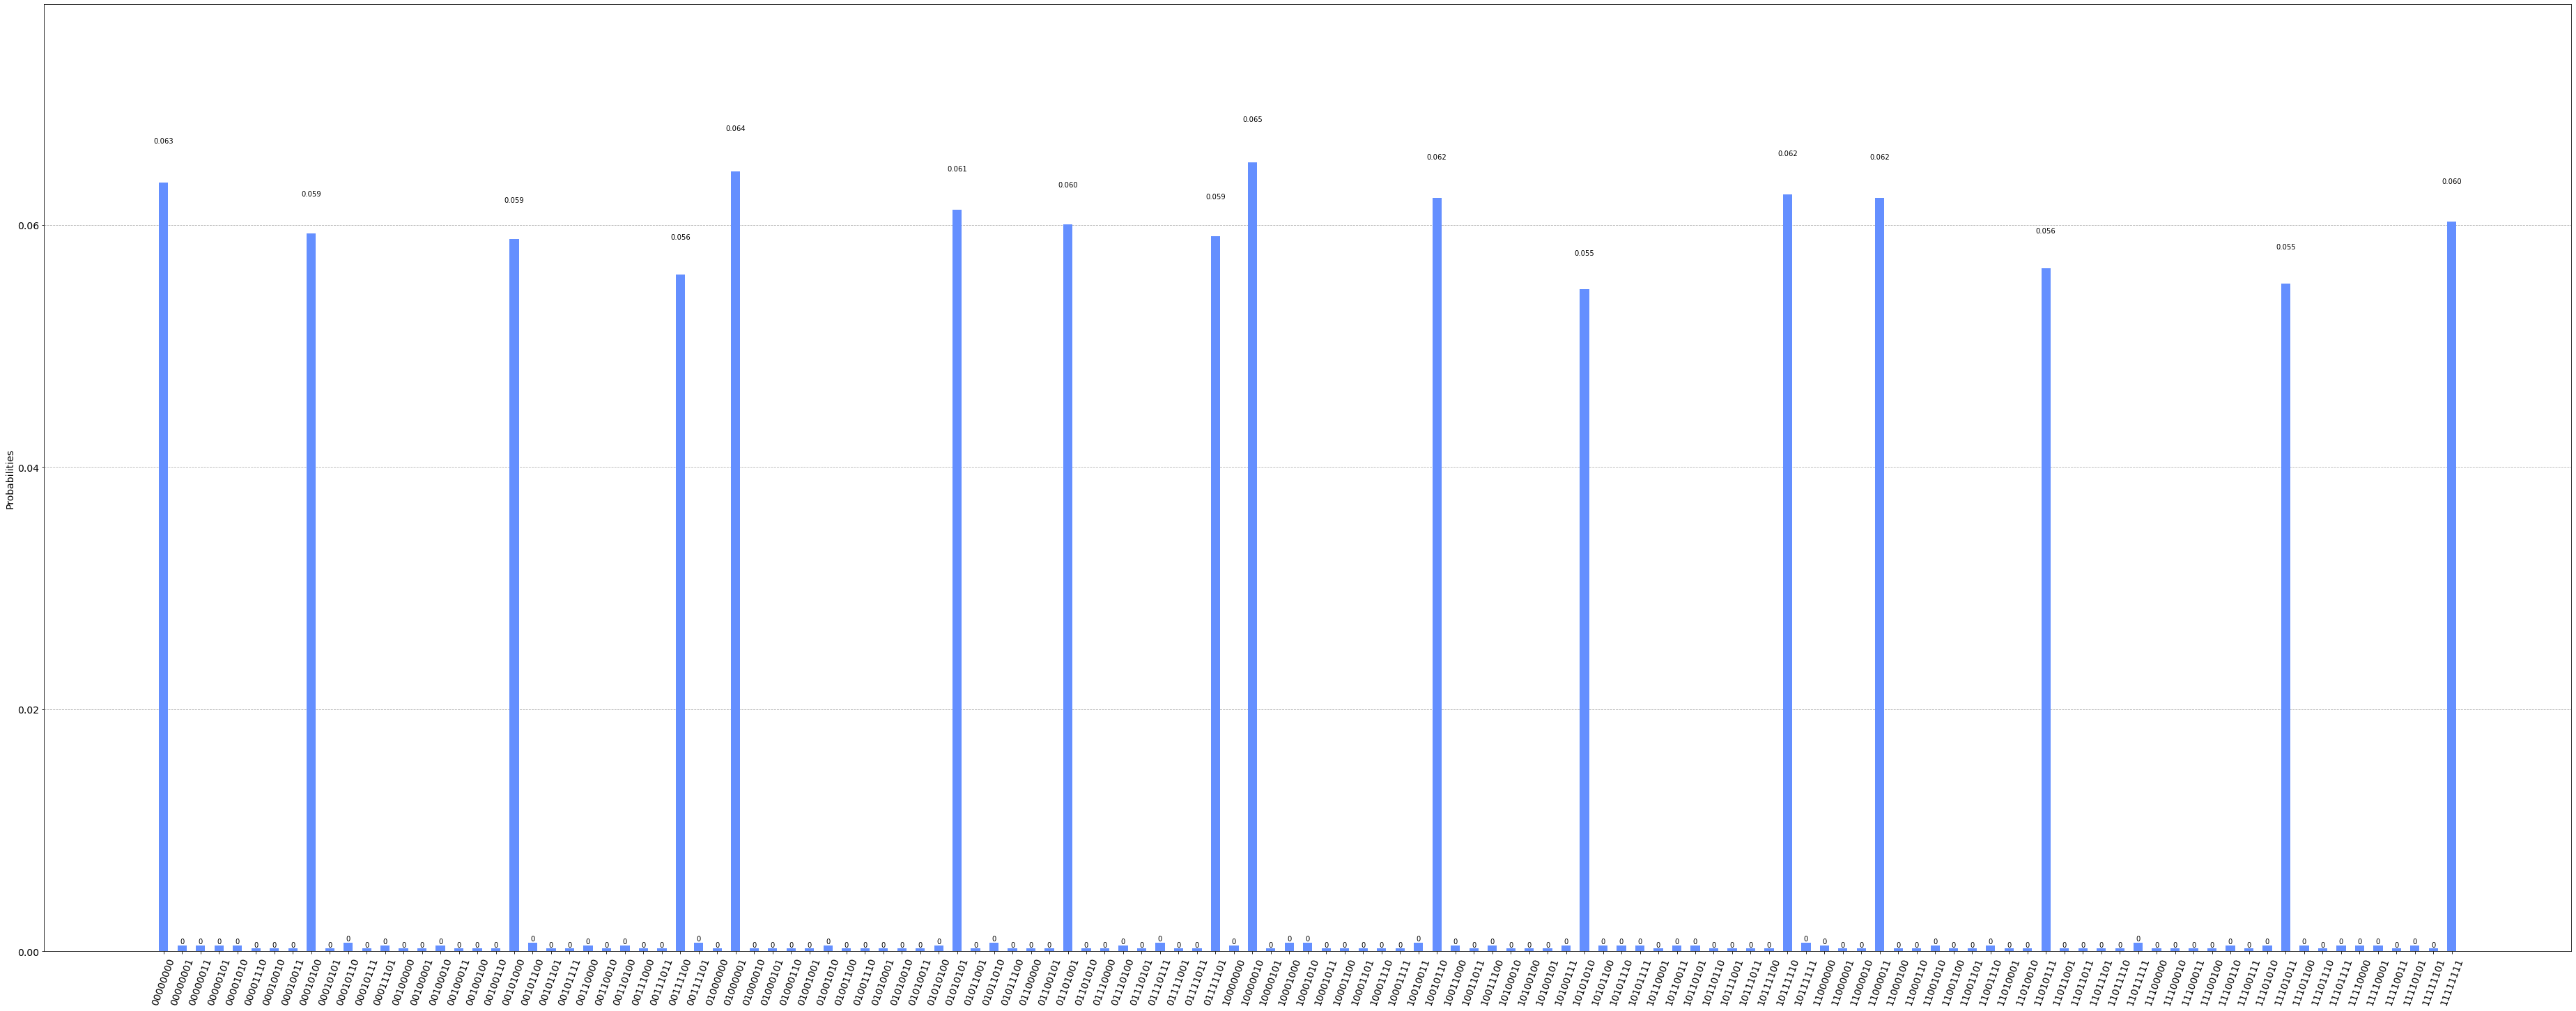

In [19]:
backend = Aer.get_backend('qasm_simulator')
shots = 4096 #max number of shots possible
job = execute(Grover_circuit, backend, shots = shots)
results = job.result()
counts = results.get_counts()
print('Find palindromes amongst the letters A, G, T, C :')
plot_histogram(counts, figsize=(65, 25))

From the obtained outputs the outputs which have a count less than $1 percent $ of the total number of shots can be neglected. Finally we can obtain the palindromes from the reamining bit strings based on the above explanation given while defining the oracle. 

In [20]:
sort_orders = sorted(counts.items(), key=lambda x:x[1], reverse = True)

m = 1
total_percentage = 0 
for i in sort_orders:
    if(i[1] > shots/100): #print only those which have counts more than 1% of the total shots
        print("solution number ", m)
        print("bit string = ", i[0])
        print("Probability : ", i[1], "/", shots, " or ", (i[1]/shots)*100, " %")
        total_percentage += (i[1]/shots)*100 
        for j in range(0, len(i[0]), 2):
            if(i[0][j] == '0' and i[0][j+1] == '0'):
                print('A', end='')
            elif(i[0][j] == '0' and i[0][j+1] == '1'):
                print('G', end='')
            elif(i[0][j] == '1' and i[0][j+1] == '0'):
                print('C', end='')
            else :
                print('T', end ='')
        print()
        
        print()
        m += 1
        
print("Total number of solutions : ", m-1)
print("Probability of getting a right answer : ", total_percentage, "%")

solution number  1
bit string =  10000010
Probability :  267 / 4096  or  6.5185546875  %
CAAC

solution number  2
bit string =  01000001
Probability :  264 / 4096  or  6.4453125  %
GAAG

solution number  3
bit string =  00000000
Probability :  260 / 4096  or  6.34765625  %
AAAA

solution number  4
bit string =  10111110
Probability :  256 / 4096  or  6.25  %
CTTC

solution number  5
bit string =  10010110
Probability :  255 / 4096  or  6.2255859375  %
CGGC

solution number  6
bit string =  11000011
Probability :  255 / 4096  or  6.2255859375  %
TAAT

solution number  7
bit string =  01010101
Probability :  251 / 4096  or  6.1279296875  %
GGGG

solution number  8
bit string =  11111111
Probability :  247 / 4096  or  6.0302734375  %
TTTT

solution number  9
bit string =  01101001
Probability :  246 / 4096  or  6.005859375  %
GCCG

solution number  10
bit string =  00010100
Probability :  243 / 4096  or  5.9326171875  %
AGGA

solution number  11
bit string =  01111101
Probability :  242 /

By simply counting the number of outputs with a count greater than 1 percent of the total number of shots we can see that the approximate number of solutions is very close to 16 (When you run the circuit, the approximation may itself be 16). This circuit was on a qasm simulator which imitates a real quantum computer. Therefore the probability of getting the right answer on a real quantum computer may be even lower than 96.2%. 
You could also run the circuit once to see whether you get the right solution each time :

one palindromes made of A, G, T, C


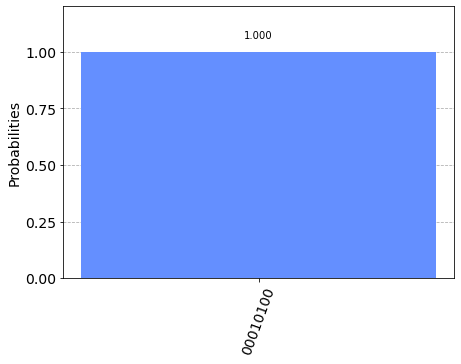

In [23]:
#if you run the circuit only once then you have approximately 96.24 % chance of getting a palindrome 
backend = Aer.get_backend('qasm_simulator')
shots = 1 
job = execute(Grover_circuit, backend, shots = shots)
results = job.result()
counts = results.get_counts()
print('one palindromes made of A, G, T, C')
plot_histogram(counts)

In [22]:
i = list(counts)

print("solution number ")
print("bit string = ", i[0])
print('Palindrome : ', end ='')
for j in range(0, len(i[0]), 2):
    if(i[0][j] == '0' and i[0][j+1] == '0'):
        print('A', end='')
    elif(i[0][j] == '0' and i[0][j+1] == '1'):
        print('G', end='')
    elif(i[0][j] == '1' and i[0][j+1] == '0'):
        print('C', end='')
    else :
        print('T', end ='')
print()

solution number 
bit string =  00000000
Palindrome : AAAA
